# DeepONet Green's function reconstruction #

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from basis_expansion.function import Function, modified_gram_schmidt

from pau import PAU as Rational

def show_trunk_activations():
    r_1 = trunk[1]
    r_2 = trunk[3]
    r_3 = trunk[-2]
    
    x = torch.linspace(-1, 1, 50)
    
    plt.plot(x, r_1(x), label='r1')
    plt.plot(x, r_2(x), label='r2')
    plt.plot(x, r_3(x), label='r3')
    plt.legend()
    plt.show()

## Poisson 1D ##

We train a DeepONet architecture to learn the solution operator of the Laplace operator over $[0,1]$ with homogeneous boundary conditions.
i.e.
$$
    -u'' = f \quad \text{ with } u(0) = u(1) = 0.
$$

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


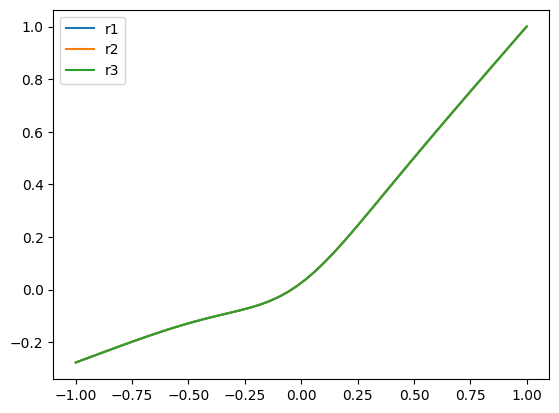

In [2]:
def init_sequential(layers):
    modules = []
    for i in range(len(layers)-2):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        modules.append(Rational())
    modules.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*modules)

lat_dim = 8
trunk = init_sequential([1, 100, 100, 8])
A = init_sequential([200, 8])

show_trunk_activations()

In [3]:
file = 'dataset/ds20k/model/10000_ds20k_basis.model'

checkpoint = torch.load(file)

trunk.load_state_dict(checkpoint['T'][0])
A.load_state_dict(checkpoint['A'][0])
epoch = checkpoint['epoch']
print(epoch)

10000


In [4]:
def trunk_at(xi):
    return trunk(xi.unsqueeze(dim=1))

def model(f, p):
    f = A(f.unsqueeze(dim=0))
    D = trunk(p.unsqueeze(dim=1))
    return torch.einsum('...pi,...i->...p', D, f)

encx = torch.linspace(0, 1, 200)
def LearnedOperator(f, p):
    return model(f(encx), p)

In [5]:
from scipy.interpolate import interp1d
import scipy.sparse as sps

Lap_size = 144
Lap_matrix = -sps.diags([torch.ones(Lap_size), -2*torch.ones(Lap_size), torch.ones(Lap_size)],
                       offsets=[-1, 0, 1],
                       shape=(Lap_size, Lap_size),
                       format='csc') * (Lap_size-1)**2
Lap_x = torch.linspace(0, 1, Lap_size)

def TrueOperator(f, p):
    u = Lap_matrix @ f(Lap_x)
    # u = sps.linalg.spsolve(Lap_matrix, f(Lap_x))
    return interp1d(Lap_x, u, copy=False)(p)

In [6]:
#  Define a quadrature rule. Here: trapezoidal in each element.
n_elem = 200
area_elem = (1/(n_elem-1))
int_p = torch.linspace(0, 1, n_elem)
int_w = torch.ones(n_elem) * area_elem
int_w[[0,-1]] /= 2

def L2_inner_1d(u, v, int_p, int_w):
    return (u(int_p) * v(int_p)) @ int_w

def eigv_rayleigh(G, f, inv=False):
    num = (f(int_p) * G(f, int_p)) @ int_w
    den = (f(int_p) * f(int_p)) @ int_w
    return num / den if not inv else den / num

def eigv_mean(G, f):
    return torch.mean(G(f, Lap_x[1:-1]) / f(Lap_x[1:-1]))

N = 200
x = torch.linspace(0, 1, N)

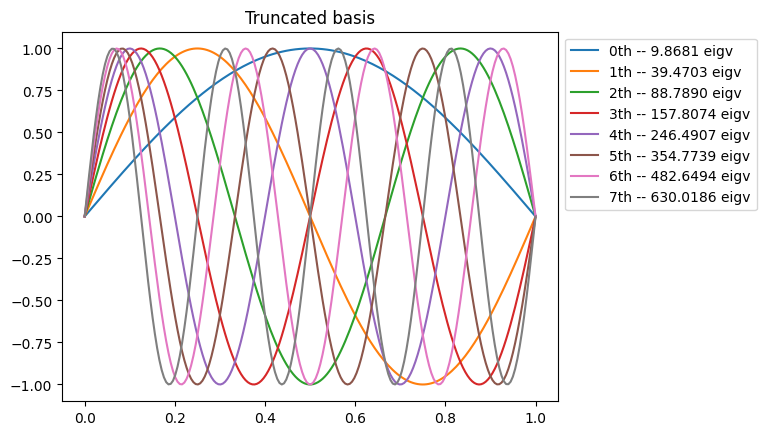

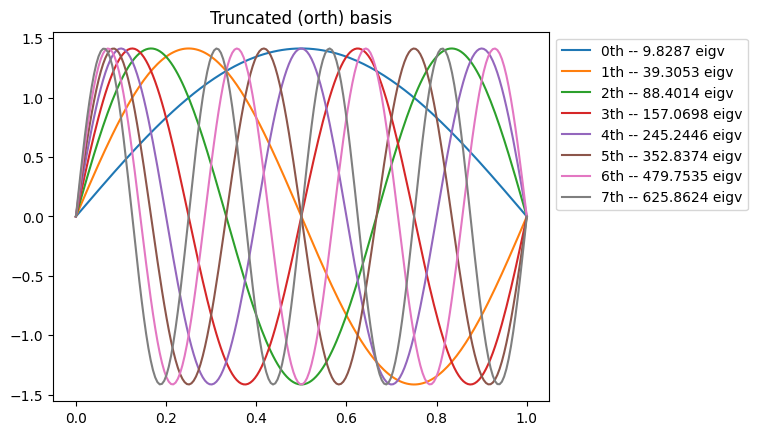

In [7]:
truncated_basis = [
    Function(lambda xi, n=n: torch.sin(torch.pi*xi*n))
    for n in range(1, lat_dim+1)
]

truncated_eigv = tuple(
    eigv_mean(TrueOperator, b)
    for b in truncated_basis
)

truncated_info = tuple(zip(truncated_basis, truncated_eigv))

for n, (b, i) in enumerate(truncated_info):
    plt.plot(x, b(x), label=f'{n}th -- {i:4.4f} eigv')

plt.title('Truncated basis')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#  Orthonormalization
truncated_orth_basis, _ = modified_gram_schmidt(truncated_basis, int_p, int_w, inner=L2_inner_1d)

truncated_orth_eigv = tuple(
    eigv_rayleigh(TrueOperator, b)
    for b in truncated_basis
)

truncated_orth_info = tuple(zip(truncated_orth_basis, truncated_orth_eigv))

for n, (b, i) in enumerate(truncated_orth_info):
    plt.plot(x, b(x), label=f'{n}th -- {i:4.4f} eigv')

plt.title('Truncated (orth) basis')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

We also performed the $L^2$ gram-schmidt process to ensure orthonormality.

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


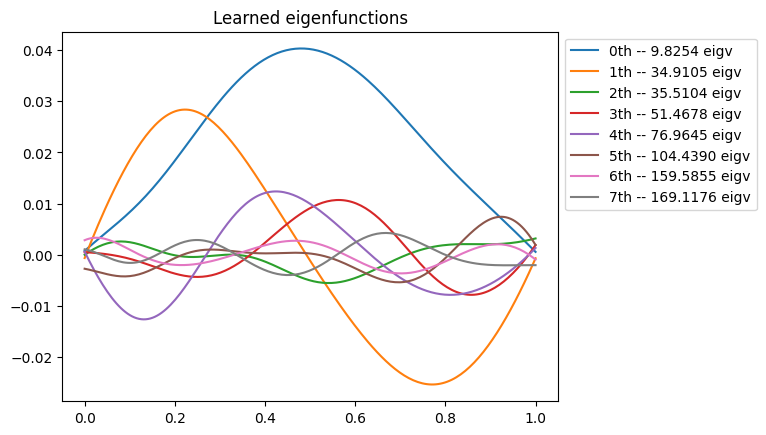

/tmp/ipykernel_9124/1164080609.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basis = torch.stack([torch.tensor(b(int_p)) for b, _ in learned_info])


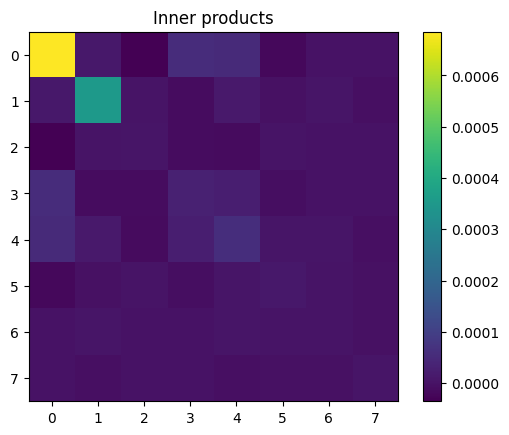

In [8]:
learned_basis = [
    Function(lambda xi, n=i: trunk_at(xi)[:, n]) 
    for i in range(8)
]

learned_eigv = [
    eigv_rayleigh(LearnedOperator, b, inv=True)
    for b in learned_basis
]

learned_info = sorted([
    (Function(lambda x, v=v, b=b: b(x) * torch.sign(v)), abs(v)) 
    for b, v in zip(learned_basis, learned_eigv)
], key=lambda x: x[1])[:lat_dim]

with torch.no_grad():
    for n, (b, i) in enumerate(learned_info):
        plt.plot(x, b(x), label=f'{n}th -- {i.item():4.4f} eigv')
    plt.title('Learned eigenfunctions')
    plt.legend(bbox_to_anchor=(1, 1))
    # plt.savefig(f'don_eigfun8_ds5k_epoch{epoch}.png')
    plt.show()

with torch.no_grad():
    basis = torch.stack([torch.tensor(b(int_p)) for b, _ in learned_info])
    C = torch.einsum('fp,gp,p->fg', basis, basis, int_w)
    plt.imshow(C)
    plt.title('Inner products')
    plt.colorbar(location='right')
    plt.show()

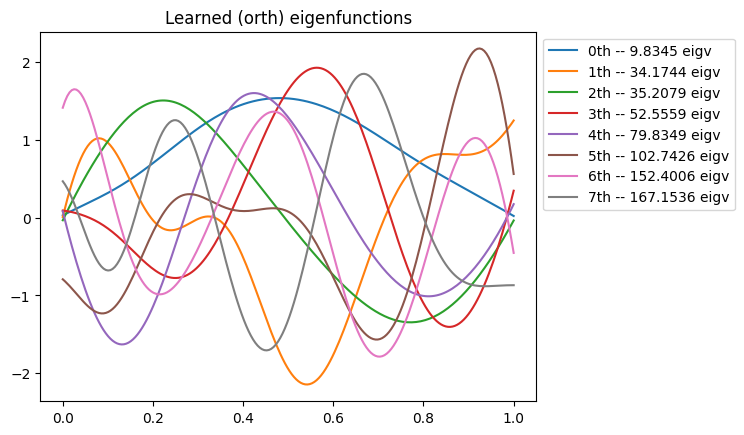

/tmp/ipykernel_9124/3728609188.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basis = torch.stack([torch.tensor(b(int_p)) for b, _ in learned_orth_info])


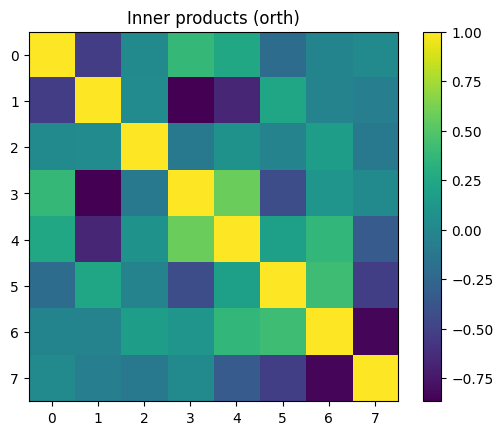

In [9]:
#  Orthonormalization
learned_orth_basis, _ = modified_gram_schmidt([b for (b, _) in learned_info], int_p, int_w, inner=L2_inner_1d)
learned_orth_basis = tuple(learned_orth_basis)

learned_orth_eigv = tuple(
    eigv_rayleigh(LearnedOperator, b, inv=True)
    for b in learned_orth_basis
)

learned_orth_info = tuple(sorted([
    (Function(lambda x, v=v, b=b: b(x) * torch.sign(v)), abs(v)) 
    for b, v in zip(learned_orth_basis, learned_orth_eigv)
], key=lambda x: x[1])[:lat_dim])


with torch.no_grad():
    for n, (b, i) in enumerate(learned_orth_info):
        plt.plot(x, b(x), label=f'{n}th -- {i.item():4.4f} eigv')
    plt.title('Learned (orth) eigenfunctions')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

with torch.no_grad():
    basis = torch.stack([torch.tensor(b(int_p)) for b, _ in learned_orth_info])
    C = torch.einsum('fp,gp,p->fg', basis, basis, int_w)
    plt.imshow(C)
    plt.title('Inner products (orth)')
    plt.colorbar(location='right')
    plt.show()

## Green's Functions

In [10]:
def vGreenTrunc(x, y):
    s = torch.zeros(lat_dim, len(x))
    for n, (b, i) in enumerate(truncated_orth_info):
        s[n, :] = b(x) * b(y) / i
    return torch.einsum('nx->x', s)

def vGreenLearned(x, y):
    s = torch.zeros(lat_dim, len(x))
    for n, (b, i) in enumerate(learned_orth_info):
        s[n, :] = b(x) * b(y) / i
    return torch.einsum('nx->x', s)

def vGreenClosedForm(x, y):
    g = torch.zeros_like(x)
    cond = x < y
    g[cond] = x[cond]*(1-y[cond])
    g[~cond] = y[~cond]*(1-x[~cond])
    return g

In [11]:
x = torch.linspace(0, 1, 150)
X, Y = torch.meshgrid(x, x, indexing='xy')

Xravel = X.ravel()
Yravel = Y.ravel()

In [12]:
green_exact = vGreenClosedForm(Xravel, Yravel).view(X.shape)
green_trunc = vGreenTrunc(Xravel, Yravel).view(X.shape)
green_learned = vGreenLearned(Xravel, Yravel).view(X.shape).detach()

L2error Exact vs Exact Trun. 5.736532330047339e-06
L2error Exact Trun. vs Learned 0.0028638162184506655
L2error Exact vs Learned 0.0028783564921468496


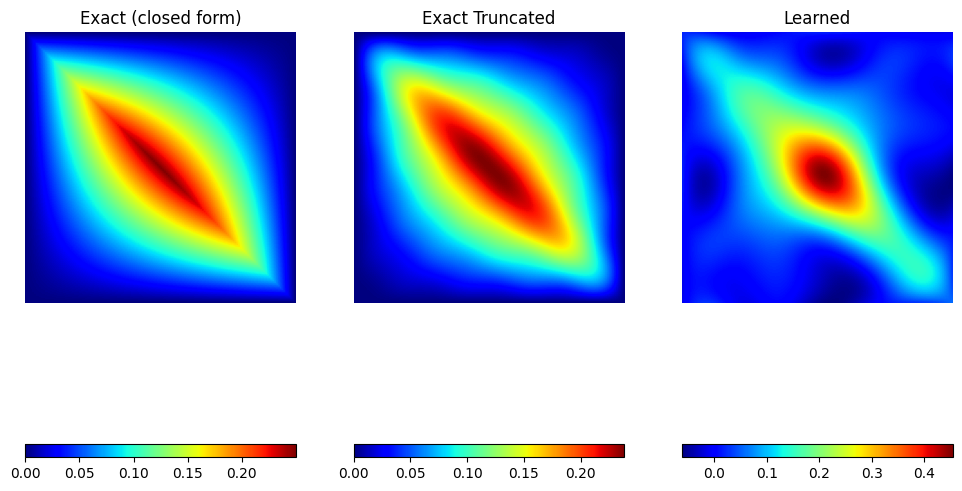

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(10,10))
fig.tight_layout()

#  Montecarlo estimation
print('L2error Exact vs Exact Trun.', torch.mean((green_exact - green_trunc)**2).item())
print('L2error Exact Trun. vs Learned', torch.mean((green_trunc - green_learned)**2).item())
print('L2error Exact vs Learned', torch.mean((green_exact - green_learned)**2).item())

for i, (title, data) in enumerate([
    ('Exact (closed form)', green_exact),
    ('Exact Truncated', green_trunc),
    ('Learned', green_learned)
]):
    a = ax.flat[i]
    p = a.imshow(data, cmap='jet')
    a.axis('off')
    a.set_title(title)
    fig.colorbar(p, ax=(lambda e: e)(a), location='bottom')
# plt.savefig(f'don_eigfun8_ds5k_epoch{epoch}_greencomparison.png')
plt.show()

## Examination of learned-activations



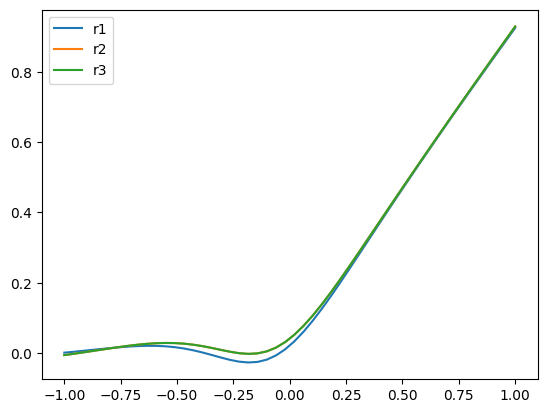

In [14]:
show_trunk_activations()

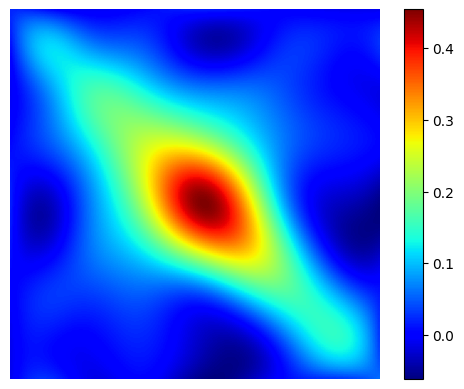

In [15]:
plt.imshow(green_learned, cmap='jet')
plt.axis('off')
plt.colorbar(location='right')
#plt.savefig(f'don_eigfun8_epoch{epoch}_greenrecon.png')
plt.show()